# Importing Necessary Python Libraries for Data Processing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')


# Reading the Dataset

In [2]:
df = pd.read_csv('/content/airline_passengers.csv')
df.head(3)

,Month,Thousands of Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Month                    144 non-null    object
 1   Thousands of Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [4]:
df['Month'] = pd.to_datetime(df['Month'])

In [5]:
df.set_index('Month', inplace = True)

# Dissecting the data to check for Trend, Seasonality, Cyclicity and Noise

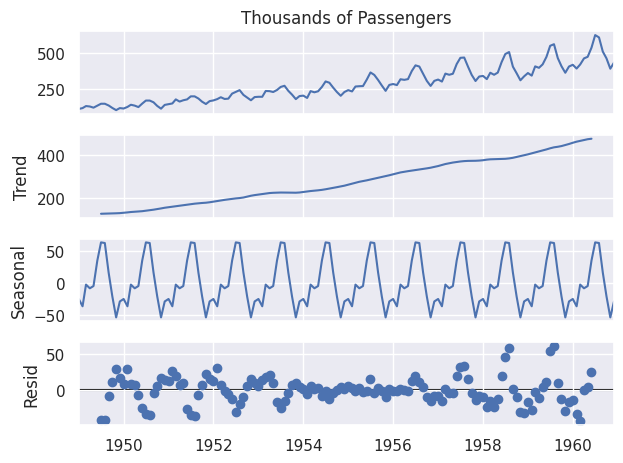

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose = seasonal_decompose(df['Thousands of Passengers'], model = 'additive', period = 12)
decompose.plot()
plt.savefig('Trend_Seasonality_plot.jpg', dpi = 480)
plt.show()

# Checking if data is a regression or TSA problem using Durbin Watson test

In [17]:
import statsmodels.api as sm
print(sm.stats.durbin_watson(df['Thousands of Passengers']))

0.0121527966037621


# Checking if data is Stationary using Augmented Dickey Fuller Test

In [20]:
from statsmodels.tsa.stattools import adfuller
def adf_test(col):
  result = adfuller(col)
  print('ADF Statistic: {}'.format(result[0]))
  print('p-value: {}'.format(result[1]))
  print('------'*10)
  if result[1] <= 0.05:
    print('Strong Evidence against null hypothesis and the data is Stationary')
  else:
    print('Weak Evidence against null hypothesis and the data is Non-Stationary')

adf_test(df['Thousands of Passengers'])

ADF Statistic: 0.8153688792060498
p-value: 0.991880243437641
------------------------------------------------------------
Weak Evidence against null hypothesis and the data is Non-Stationary


# Since data is non-stationary, we to make it stationary before we proceed with TSA

In [23]:
df['1st_diff'] = df['Thousands of Passengers'] - df['Thousands of Passengers'].shift(1)
adf_test(df['1st_diff'].dropna())

ADF Statistic: -2.8292668241700047
p-value: 0.05421329028382478
------------------------------------------------------------
Weak Evidence against null hypothesis and the data is Non-Stationary


In [24]:
df['2nd_diff'] = df['1st_diff'] - df['1st_diff'].shift(1)
adf_test(df['2nd_diff'].dropna())

ADF Statistic: -16.384231542468513
p-value: 2.7328918500142026e-29
------------------------------------------------------------
Strong Evidence against null hypothesis and the data is Stationary


# Now the data is stationary and TSA can be performed

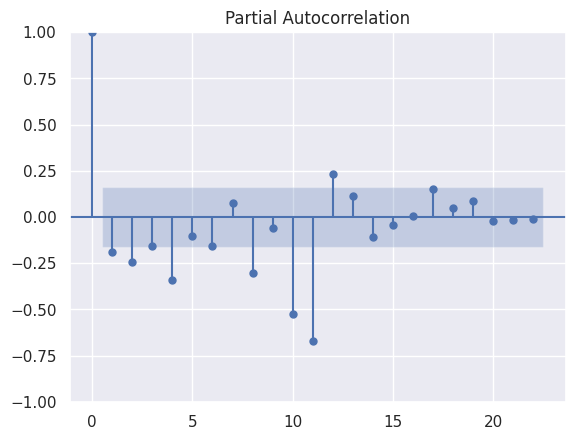

In [37]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
plot_pacf(df['2nd_diff'].dropna())
plt.show()

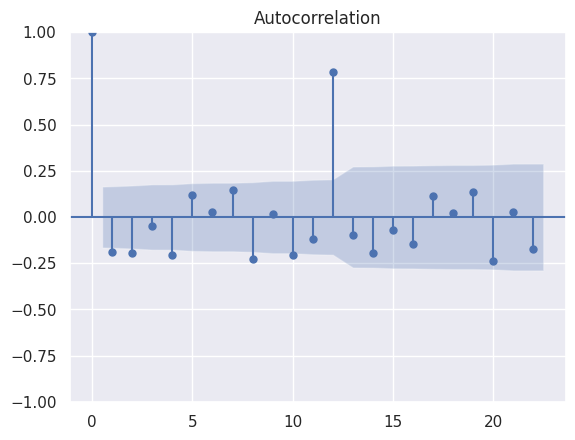

In [38]:
plot_acf(df['2nd_diff'].dropna())
plt.show()

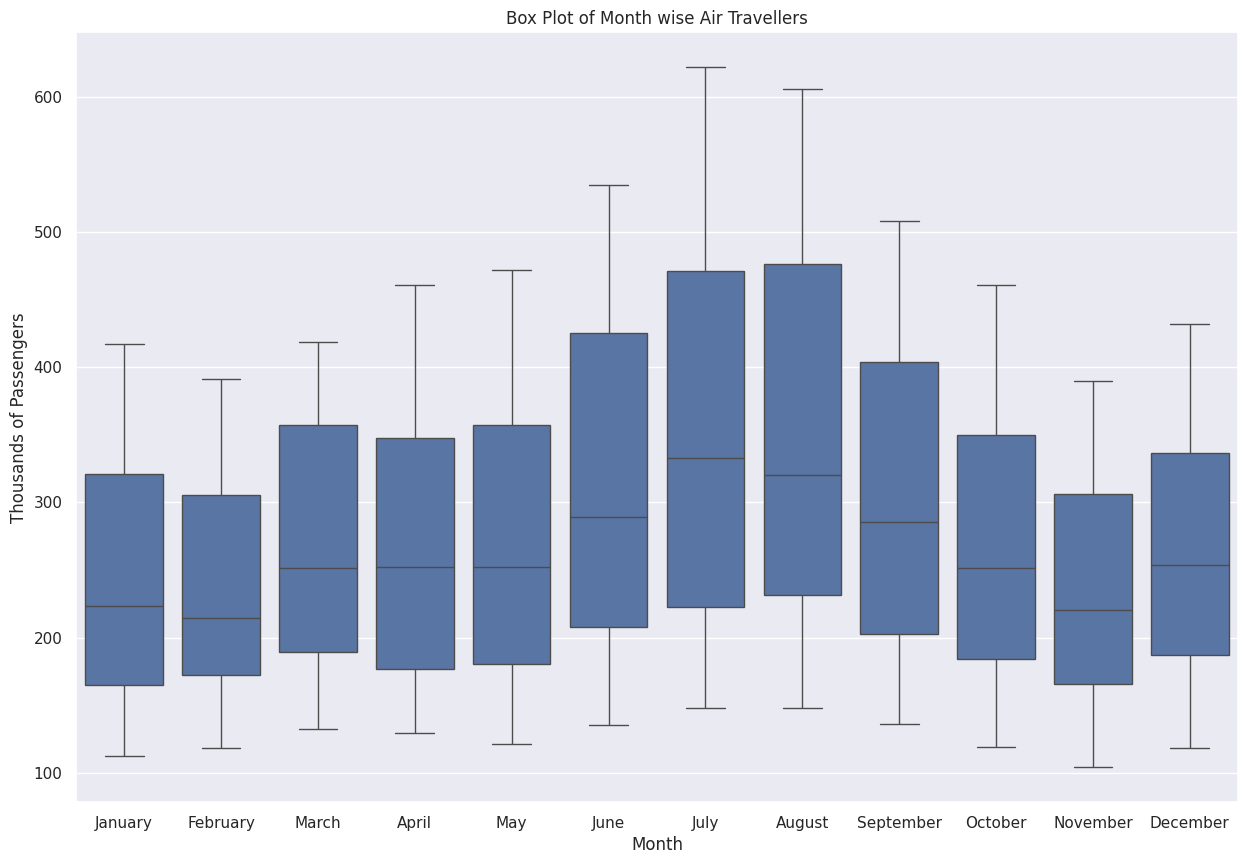

In [69]:
plt.figure(figsize = (15,10))
sns.boxplot(data= df, y = df['Thousands of Passengers'], x = df.index.month_name())
plt.title('Box Plot of Month wise Air Travellers')
plt.savefig('Month wise Travellers.jpg', dpi = 480)
plt.show()

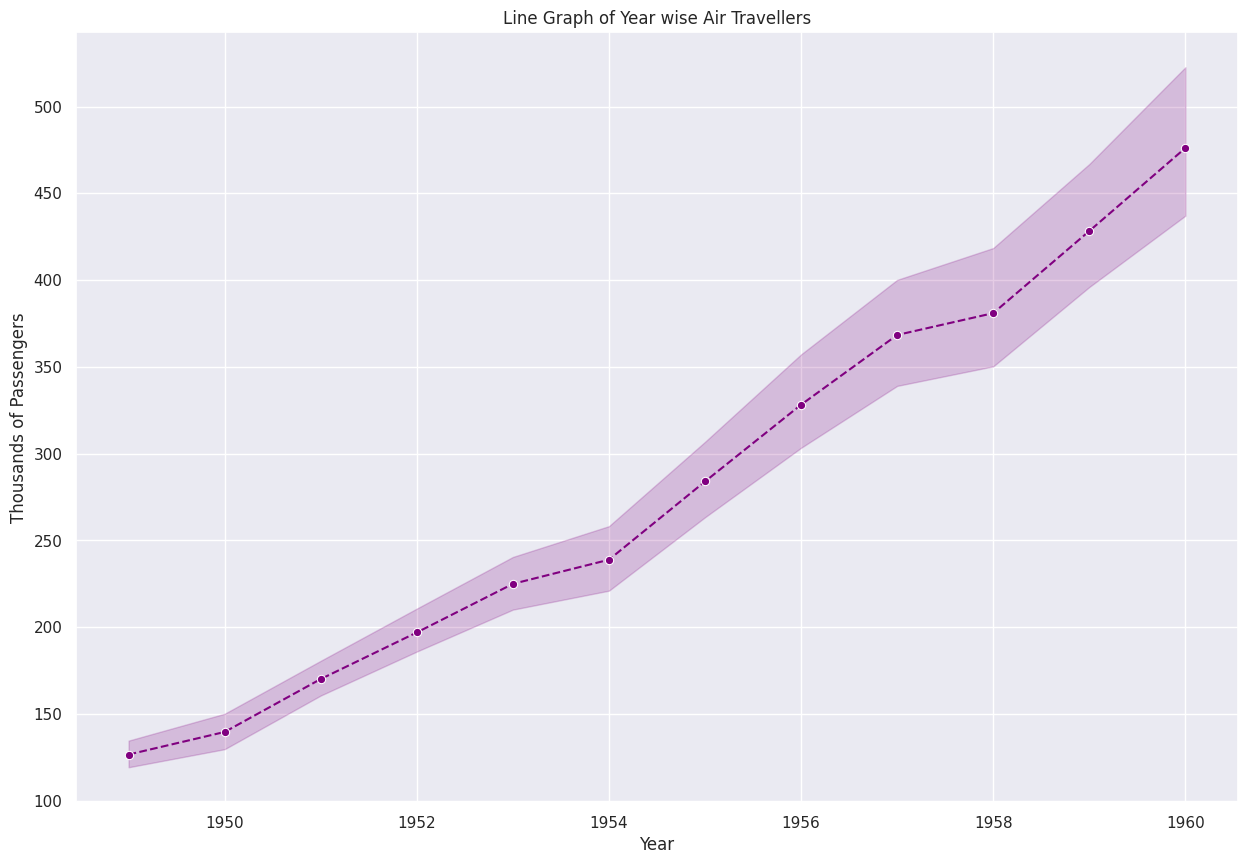

In [80]:
plt.figure(figsize = (15,10))
sns.lineplot(data= df, y = df['Thousands of Passengers'], x = df.index.year, marker='o', linestyle='--', color='purple')
plt.xlabel('Year')
plt.ylabel('Thousands of Passengers')
plt.title('Line Graph of Year wise Air Travellers')
plt.savefig('Year wise Travellers.jpg', dpi = 480)
plt.show()

# Key Insights:

*   Going by the median, People are travelling in large numbers during Jul, Aug and Sep
*   People are travelling less during Jan, Feb and Nov



In [36]:
df['Seasonality'] = df['Thousands of Passengers'].shift(12)
df.head()

,Thousands of Passengers,1st_diff,2nd_diff,Seasonality
Month,,,,
1949-01-01,112,NaN,NaN,NaN
1949-02-01,118,6.0,NaN,NaN
1949-03-01,132,14.0,8.0,NaN
1949-04-01,129,-3.0,-17.0,NaN
1949-05-01,121,-8.0,-5.0,NaN


In [39]:
adf_test(df['2nd_diff'].dropna())

ADF Statistic: -16.384231542468513
p-value: 2.7328918500142026e-29
------------------------------------------------------------
Strong Evidence against null hypothesis and the data is Stationary


#Using the SARIMA Model

In [45]:
import itertools
p = d= q= range(0,2)
pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0],x[1],x[2],12) for x in pdq]

In [48]:
for i in pdq:
  for j in seasonal_pdq:
    model = sm.tsa.statespace.SARIMAX(df['Thousands of Passengers'], order = i, seasonal_order = j, enforce_stationarity = False, enforce_invertibility = False)
    results = model.fit()
    print('SARIMA{}x{} - AIC:{}'.format(i,j,results.aic))

SARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:2044.4329486427587
SARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:1887.3336957046115
SARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:1315.9211929474204
SARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:1156.2914901508536
SARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:1118.6259190717344
SARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:1107.2562043241846
SARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:1109.2437994445113
SARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:1033.6172166729725
SARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:1846.0789377571616
SARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC:1567.9916312317516
SARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC:1196.998361439986
SARIMA(0, 0, 1)x(0, 1, 1, 12) - AIC:1072.1382984044296
SARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:1071.0026809496385
SARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC:1049.5801412336764
SARIMA(0, 0, 1)x(1, 1, 0, 12) - AIC:1059.5112223290448
SARIMA(0, 0, 1)x(1, 1, 1, 12) - AIC:985.3346478031496
SARIMA(0, 1, 0)x(0, 0, 0, 12) - AIC:1405.0006612949667
SARIMA(0, 1, 0)x(0, 0, 1, 12) - AIC:1194.7130010979654
SARIMA(0, 1,

# Lowest AIC was obtained for the below combination of 0,1,1 in trend and 1,1,1 in seasonality


In [54]:
model = sm.tsa.statespace.SARIMAX(df['Thousands of Passengers'], order = (0,1,1), seasonal_order = (1,1,1,12), enforce_stationarity = False, enforce_invertibility = False)
results = model.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:            Thousands of Passengers   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -456.160
Date:                            Sun, 10 Nov 2024   AIC                            920.319
Time:                                    16:24:06   BIC                            931.368
Sample:                                01-01-1949   HQIC                           924.805
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3351      0.076     -4.403      0.000      -0.484      -0.186
ar.S.L12      -0.5597      0.285   

# Now to visualize how robust the model is !!

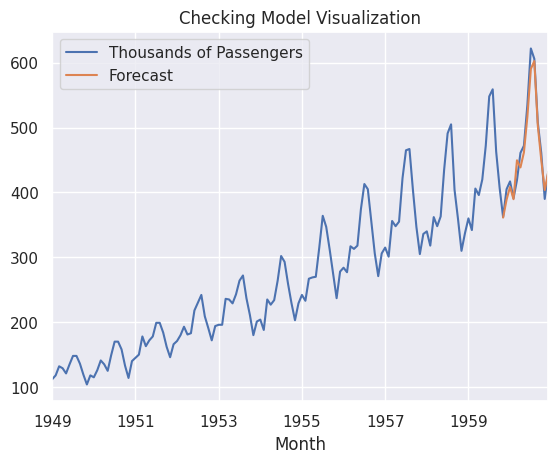

In [79]:
df['Forecast'] = results.predict(start=130, end=144, dynamic=True)
df[['Thousands of Passengers','Forecast']].plot()
plt.title('Checking Model Visualization')
plt.savefig("Checking Model Visualization.jpg", dpi = 480)
plt.show()

In [63]:
from pandas.tseries.offsets import DateOffset
future_dates = [df.index[-1] + DateOffset(months = x) for x in range(1,61)]
future_dates

[Timestamp('1961-01-01 00:00:00'),
 Timestamp('1961-02-01 00:00:00'),
 Timestamp('1961-03-01 00:00:00'),
 Timestamp('1961-04-01 00:00:00'),
 Timestamp('1961-05-01 00:00:00'),
 Timestamp('1961-06-01 00:00:00'),
 Timestamp('1961-07-01 00:00:00'),
 Timestamp('1961-08-01 00:00:00'),
 Timestamp('1961-09-01 00:00:00'),
 Timestamp('1961-10-01 00:00:00'),
 Timestamp('1961-11-01 00:00:00'),
 Timestamp('1961-12-01 00:00:00'),
 Timestamp('1962-01-01 00:00:00'),
 Timestamp('1962-02-01 00:00:00'),
 Timestamp('1962-03-01 00:00:00'),
 Timestamp('1962-04-01 00:00:00'),
 Timestamp('1962-05-01 00:00:00'),
 Timestamp('1962-06-01 00:00:00'),
 Timestamp('1962-07-01 00:00:00'),
 Timestamp('1962-08-01 00:00:00'),
 Timestamp('1962-09-01 00:00:00'),
 Timestamp('1962-10-01 00:00:00'),
 Timestamp('1962-11-01 00:00:00'),
 Timestamp('1962-12-01 00:00:00'),
 Timestamp('1963-01-01 00:00:00'),
 Timestamp('1963-02-01 00:00:00'),
 Timestamp('1963-03-01 00:00:00'),
 Timestamp('1963-04-01 00:00:00'),
 Timestamp('1963-05-

In [65]:
future_df = pd.DataFrame(index = future_dates, columns = df.columns)
future_df

,Thousands of Passengers,1st_diff,2nd_diff,Seasonality,Forecast
1961-01-01,NaN,NaN,NaN,NaN,NaN
1961-02-01,NaN,NaN,NaN,NaN,NaN
1961-03-01,NaN,NaN,NaN,NaN,NaN
1961-04-01,NaN,NaN,NaN,NaN,NaN
1961-05-01,NaN,NaN,NaN,NaN,NaN
1961-06-01,NaN,NaN,NaN,NaN,NaN
1961-07-01,NaN,NaN,NaN,NaN,NaN
1961-08-01,NaN,NaN,NaN,NaN,NaN
1961-09-01,NaN,NaN,NaN,NaN,NaN
1961-10-01,NaN,NaN,NaN,NaN,NaN


In [66]:
final_df = pd.concat([df, future_df])
final_df

,Thousands of Passengers,1st_diff,2nd_diff,Seasonality,Forecast
1949-01-01,112,NaN,NaN,NaN,NaN
1949-02-01,118,6.0,NaN,NaN,NaN
1949-03-01,132,14.0,8.0,NaN,NaN
1949-04-01,129,-3.0,-17.0,NaN,NaN
1949-05-01,121,-8.0,-5.0,NaN,NaN
...,...,...,...,...,...
1965-08-01,NaN,NaN,NaN,NaN,NaN
1965-09-01,NaN,NaN,NaN,NaN,NaN
1965-10-01,NaN,NaN,NaN,NaN,NaN
1965-11-01,NaN,NaN,NaN,NaN,NaN


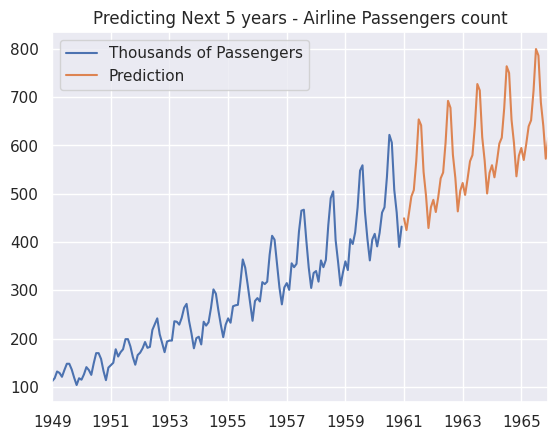

In [68]:
final_df['Prediction'] = results.predict(start = 144, end = 204, dynamic = True)
final_df[['Thousands of Passengers','Prediction']].plot()
plt.title('Predicting Next 5 years - Airline Passengers count')
plt.savefig("Final Visualization.jpg", dpi = 480)
plt.show()